In [ ]:
import cv2
import os
import numpy as np

def find_optimal_watermark_size(dataset_folder, scale_factor=0.15):
    """
    Computes the optimal watermark size based on the average image size in the dataset folder.
    The watermark size is chosen as a percentage of the average image dimensions.
    
    :param dataset_folder: Path to the dataset folder containing images
    :param scale_factor: Percentage of image size to use for watermark (default: 15%)
    :return: (wm_width, wm_height) - Optimal watermark dimensions
    """
    total_width, total_height, count = 0, 0, 0

    for filename in os.listdir(dataset_folder):
        file_path = os.path.join(dataset_folder, filename)
        img = cv2.imread(file_path)

        if img is not None:
            h, w = img.shape[:2]
            total_width += w
            total_height += h
            count += 1

    if count == 0:
        print("Error: No valid images found in the dataset folder.")
        return None

    avg_width = total_width // count
    avg_height = total_height // count

    # Optimal watermark size as 15% of average image size
    wm_width = int(avg_width * scale_factor)
    wm_height = int(avg_height * scale_factor)

    print(f"Optimal Watermark Size: {wm_width} x {wm_height}")
    return wm_width, wm_height

def resize_watermark(image_path, output_path, size):
    """
    Resizes the given watermark image to the computed optimal size.
    
    :param image_path: Path to the watermark image
    :param output_path: Path to save the resized watermark image
    :param size: (width, height) tuple for resizing
    """
    watermark = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # Preserve transparency if PNG
    if watermark is None:
        print("Error: Could not load watermark image.")
        return
    
    resized_wm = cv2.resize(watermark, size, interpolation=cv2.INTER_AREA)
    cv2.imwrite(output_path, resized_wm)
    print(f"Resized watermark saved at: {output_path}")

# ------------------------------
# Main Execution
# ------------------------------

dataset_folder = "./watermark_dataset/2048x2048"  # Change this to your dataset folder path
watermark_path = "./watermarks/original_watermark.png"  # Watermark image to resize
output_path = "./watermarks/watermark2048.png"  # Output resized watermark path

optimal_size = find_optimal_watermark_size(dataset_folder)

if optimal_size:
    resize_watermark(watermark_path, output_path, optimal_size)


In [1]:
import os
from PIL import Image

# ✅ Define source and destination folders
SOURCE_FOLDER = "testing/test_directory/256x256"  # Change to your source folder
DEST_FOLDER = "testing/test_directory/256x256"  # Change to your destination folder
TARGET_SIZE = (256, 256)  # Resize to (width, height)

# ✅ Create destination folder if it doesn't exist
os.makedirs(DEST_FOLDER, exist_ok=True)

def resize_images():
    """Resizes all images in the source folder and saves them to the destination folder."""
    
    image_count = 0

    for filename in os.listdir(SOURCE_FOLDER):
        source_path = os.path.join(SOURCE_FOLDER, filename)
        dest_path = os.path.join(DEST_FOLDER, filename)

        try:
            # Open and resize image
            with Image.open(source_path) as img:
                img = img.convert("RGB")  # Ensure consistent format
                img_resized = img.resize(TARGET_SIZE)

                # Save resized image
                img_resized.save(dest_path)
                image_count += 1
                print(f"✔ Resized and saved: {dest_path}")

        except Exception as e:
            print(f"⚠ Error processing {filename}: {e}")

    print(f"\n✅ {image_count} images resized and saved in '{DEST_FOLDER}'.")

# ✅ Run the script
resize_images()


✔ Resized and saved: testing/test_directory/256x256\adler-bird-bird-of-prey-raptor-53587.jpeg
✔ Resized and saved: testing/test_directory/256x256\africa-animal-big-brown-41176.jpeg
✔ Resized and saved: testing/test_directory/256x256\agriculture-arable-clouds-countryside.jpg
✔ Resized and saved: testing/test_directory/256x256\allgau-eisenberg-ostallgau-bavaria-161097.jpeg

✅ 4 images resized and saved in 'testing/test_directory/256x256'.


In [4]:
import os
import re
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr

# Supported image extensions
VALID_EXTENSIONS = {".png", ".jpg", ".jpeg", ".bmp", ".tiff"}

def find_original_image(original_folder, noisy_filename):
    """Match original files with flexible name handling"""
    # Clean noisy filename
    base_name = re.sub(
        r'(_gaussian|_saltpepper|_speckle|-\d+)(\..*)?$', 
        '', 
        os.path.splitext(noisy_filename)[0],
        flags=re.IGNORECASE
    ).lower()

    # Search originals with multiple extension checks
    for file in os.listdir(original_folder):
        original_base = os.path.splitext(file)[0].lower()
        if original_base == base_name:
            return os.path.join(original_folder, file)
        
    # Fallback: Try first part before first underscore
    fallback_base = base_name.split('_')[0]
    for file in os.listdir(original_folder):
        original_base = os.path.splitext(file)[0].lower()
        if original_base.startswith(fallback_base):
            return os.path.join(original_folder, file)
    
    print(f"No original found for {noisy_filename} (searched: {base_name})")
    return None

def convert_jpeg_to_png(image, original_path):
    """Convert JPEG to PNG in memory to eliminate compression artifacts"""
    if original_path.lower().endswith(('.jpg', '.jpeg')):
        success, encoded_img = cv2.imencode('.png', image)
        if success:
            image = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
    return image

def compute_psnr(original, noisy):
    """Compute PSNR between two images."""
    return cv2.PSNR(original, noisy)

def compute_ssim(original, noisy):
    """Compute SSIM between two images."""
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    noisy_gray = cv2.cvtColor(noisy, cv2.COLOR_BGR2GRAY)
    return ssim(original_gray, noisy_gray, data_range=255)

def compute_correlation(original, noisy):
    """Compute Pearson correlation coefficient."""
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    noisy_gray = cv2.cvtColor(noisy, cv2.COLOR_BGR2GRAY)
    orig_flat = original_gray.flatten()
    noisy_flat = noisy_gray.flatten()
    if np.std(orig_flat) == 0 or np.std(noisy_flat) == 0:
        return 0
    corr, _ = pearsonr(orig_flat, noisy_flat)
    return corr

def process_images(original_folder, noisy_folder, noise_type):
    """Process images with comprehensive error handling"""
    results = []
    
    for noisy_image_name in tqdm(os.listdir(noisy_folder), desc=f"Processing {noise_type}"):
        # Validate image extension
        if not any(noisy_image_name.lower().endswith(ext) for ext in VALID_EXTENSIONS):
            continue
            
        noisy_path = os.path.join(noisy_folder, noisy_image_name)
        original_path = find_original_image(original_folder, noisy_image_name)
        
        if not original_path or not os.path.exists(original_path):
            print(f"Skipping {noisy_image_name}: Original not found")
            continue

        try:
            # Read and validate images
            original = cv2.imread(original_path)
            noisy = cv2.imread(noisy_path)
            
            if original is None or noisy is None:
                raise ValueError("Failed to read image(s)")
                
            # Convert JPEG originals to PNG format
            original = convert_jpeg_to_png(original, original_path)
            
            # Validate image dimensions
            if original.shape != noisy.shape:
                raise ValueError(f"Dimension mismatch: Original {original.shape} vs Noisy {noisy.shape}")
            
            # Get resolution from folder name
            resolution = os.path.basename(original_folder)
            
            # Compute metrics
            metrics = {
                "psnr": compute_psnr(original, noisy),
                "ssim": compute_ssim(original, noisy),
                "corr": compute_correlation(original, noisy)
            }
            
            results.append([
                resolution,
                noise_type,
                noisy_image_name,
                metrics["psnr"],
                metrics["ssim"],
                metrics["corr"]
            ])
            
        except Exception as e:
            print(f"Error processing {noisy_image_name}: {str(e)}")
            continue
            
    return results

def main():
    original_root = os.path.abspath("./testing/test_directory")
    noisy_root = os.path.abspath("./testing/res_with_noise")
    all_results = []

    # Process each resolution folder in noisy images
    for resolution_folder in os.listdir(noisy_root):
        res_path = os.path.join(noisy_root, resolution_folder)
        if not os.path.isdir(res_path):
            continue

        # Get matching original folder
        original_folder = os.path.join(original_root, resolution_folder)
        if not os.path.exists(original_folder):
            print(f"Skipping {resolution_folder}: No matching original folder")
            continue

        # Process each noise type in resolution folder
        for noise_type in os.listdir(res_path):
            noisy_folder = os.path.join(res_path, noise_type)
            if not os.path.isdir(noisy_folder):
                continue

            # Process images for this noise type
            results = process_images(
                original_folder, 
                noisy_folder,
                noise_type.capitalize()  # Format noise name
            )
            all_results.extend(results)

    # Save results
    df = pd.DataFrame(all_results, columns=[
        "Resolution", "Noise Type", "Image Name", 
        "PSNR", "SSIM", "Correlation"
    ])
    df.to_csv("performance_metrics.csv", index=False)
    print(f"Saved metrics for {len(df)} images")

# Keep all other functions identical to previous version
# (process_images, compute_psnr, compute_ssim, compute_correlation, 
#  convert_jpeg_to_png)

if __name__ == "__main__":
    main()

Processing Uniform: 100%|██████████| 4/4 [00:00<00:00,  8.99it/s]

Saved metrics for 80 images


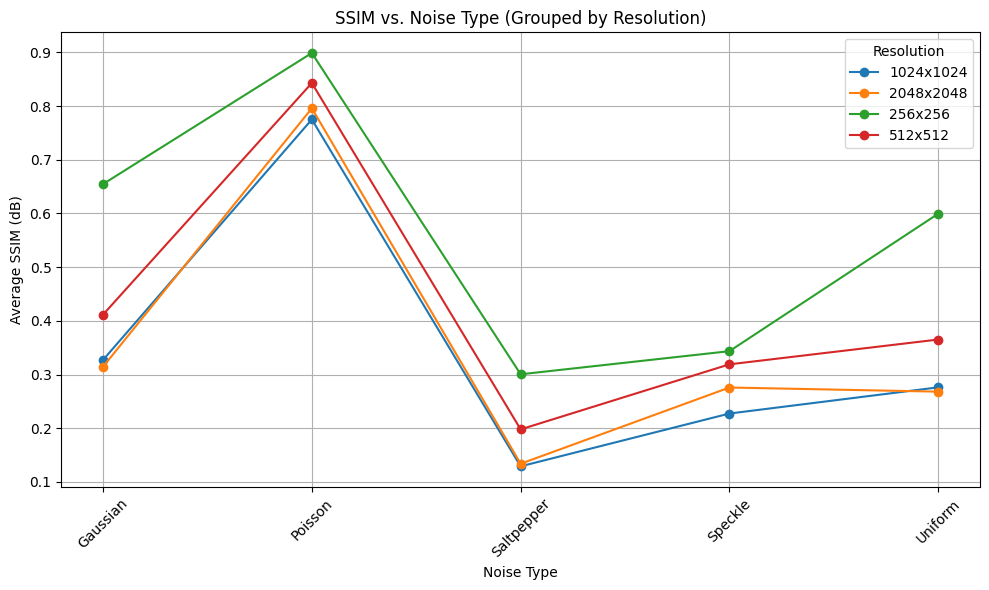

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("performance_metrics.csv")

# Group by Noise Type and Resolution, then calculate the average PSNR for each combination
avg_df = df.groupby(["Noise Type", "Resolution"])["SSIM"].mean().reset_index()

# Sort data to maintain order in the plot
avg_df = avg_df.sort_values(by=["Noise Type", "Resolution"])

# Extract unique resolutions
resolutions = avg_df["Resolution"].unique()

# Plot
plt.figure(figsize=(10, 6))

for res in resolutions:
    subset = avg_df[avg_df["Resolution"] == res]
    plt.plot(subset["Noise Type"], subset["SSIM"], marker="o", linestyle="-", label=f"{res}")

# Labels and title
plt.xlabel("Noise Type")
plt.ylabel("Average SSIM (dB)")
plt.title("SSIM vs. Noise Type (Grouped by Resolution)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title="Resolution", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your CSV data
df = pd.read_csv("performance_metrics.csv")

# Group data by Noise Type and Resolution, computing the average PSNR for each combination.
avg_df = df.groupby(["Noise Type", "Resolution"])["PSNR"].mean().reset_index()

# Pivot the DataFrame so that Noise Type is the index and Resolution columns hold the average PSNR values.
pivot_df = avg_df.pivot(index="Noise Type", columns="Resolution", values="PSNR")

# Reset index to make plotting easier
pivot_df = pivot_df.reset_index()

# Create a grouped bar chart using seaborn or matplotlib.
plt.figure(figsize=(10, 6))

# Set the width of each bar group and number of resolution bars
bar_width = 0.15
noise_types = pivot_df["Noise Type"]
resolutions = pivot_df.columns[1:]  # All resolution columns

# Determine the x locations for groups
x = range(len(noise_types))

# Plot a bar for each resolution
for i, res in enumerate(resolutions):
    # Calculate bar positions for this resolution
    positions = [pos + bar_width * i for pos in x]
    plt.bar(positions, pivot_df[res], width=bar_width, label=f"{res}")

# Set x-axis tick labels in the middle of the group
mid_positions = [pos + bar_width*(len(resolutions)/2 - 0.5) for pos in x]
plt.xticks(mid_positions, noise_types)

# Add labels and title
plt.xlabel("Noise Type")
plt.ylabel("Average PSNR (dB)")
plt.title("Average PSNR vs. Noise Type (Grouped by Resolution)")
plt.legend(title="Resolution", loc="upper right")
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'performance_metrics.csv'

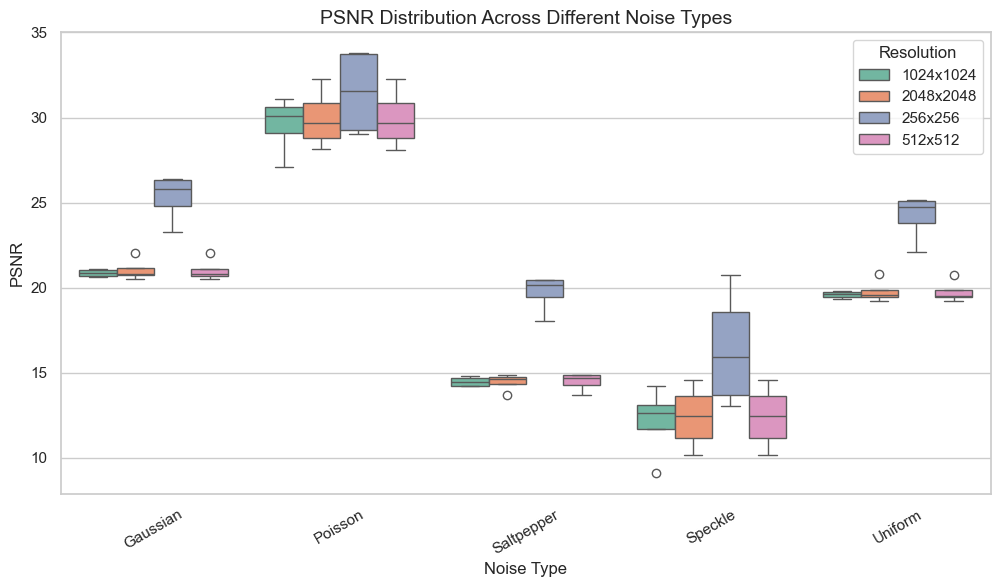

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load CSV file
df = pd.read_csv("performance_metrics.csv")  # Update with your actual file name

# Set plot style
sns.set(style="whitegrid")

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Noise Type", y="PSNR", hue="Resolution", palette="Set2")

# Add title and labels
plt.title("PSNR Distribution Across Different Noise Types", fontsize=14)
plt.xlabel("Noise Type", fontsize=12)
plt.ylabel("PSNR", fontsize=12)
plt.xticks(rotation=30)  # Rotate x-axis labels for better readability
plt.legend(title="Resolution")  # Add legend for resolutions

# Show the plot
plt.show()


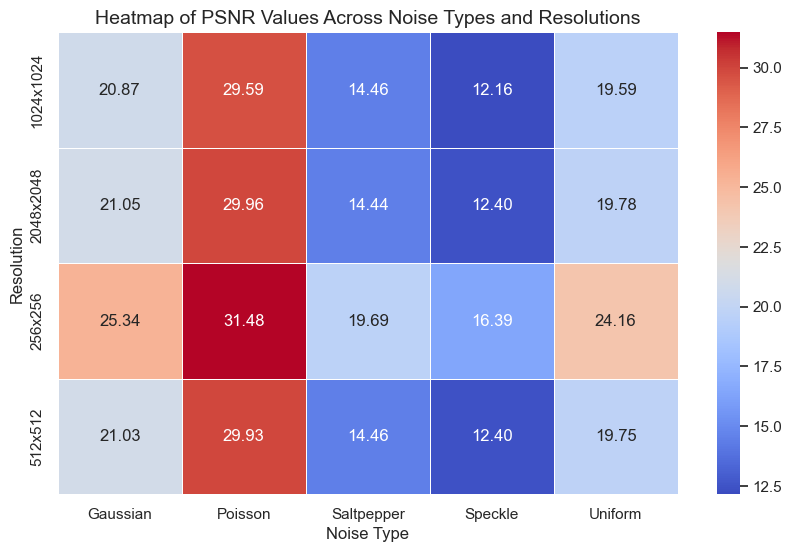

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load CSV file
df = pd.read_csv("performance_metrics.csv")  # Update with your actual file name

# Group by Resolution and Noise Type, then calculate the average PSNR
heatmap_data = df.groupby(["Resolution", "Noise Type"])["PSNR"].mean().unstack()

# Set plot size
plt.figure(figsize=(10, 6))

# Create heatmap
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Add title and labels
plt.title("Heatmap of PSNR Values Across Noise Types and Resolutions", fontsize=14)
plt.xlabel("Noise Type", fontsize=12)
plt.ylabel("Resolution", fontsize=12)

# Show the plot
plt.show()
